<h3>Feature importance by gender</h3>

<h5>Load the dataset</h5>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, RFE
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import ADASYN
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

# load adhd dataset
df = pd.read_csv('questionnaire_dataset.csv', sep=';')
feature_cols = desired_columns = ['gender', 'group'] + [f'tr{i}' for i in range(1, 44)] + [f'dass{i}' for i in range(1, 22)]
df = df[feature_cols].copy()

<h5>Screening questionnaire based on previous analysis</h5>

In [3]:
# load the screening questionnaire 
screening_questions = pd.read_csv('screening_questions.csv', sep=';')
screening_questions

,Critère DSM-5,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category
0,A,I don't really pay attention to details,tr1,Often fails to give close attention to details...,inattention
1,A,I often make careless mistakes in my activities,tr3,Often fails to give close attention to details...,inattention
2,B,I have trouble maintaining my attention at work.,tr4,Often has difficulty sustaining attention in t...,inattention
3,C,"My mind is often elsewhere, even when there is...",tr8,Often does not seem to listen when spoken to d...,inattention
4,D,I have difficulty complying with instructions,tr9,Often does not follow through on instructions ...,inattention
5,D,I have difficulty staying focused during my ac...,tr11,Often does not follow through on instructions ...,inattention
6,E,My work is often messy or disorganized,tr13,Often has difficulty organizing tasks and acti...,inattention
7,E,It is difficult for me to organize tasks that ...,tr14,Often has difficulty organizing tasks and acti...,inattention
8,F,I tend to avoid tasks that require sustained m...,tr15,"Often avoids, dislikes, or is reluctant to eng...",inattention
9,G (I),I often lose things I need for my daily life,tr18,Often loses things necessary for tasks or acti...,inattention


<h5>Balance the dataset using ADASYN</h5>

In [4]:
adasyn = ADASYN(random_state=15)
X = df.copy().drop(columns=['gender'])
y = df['gender'].copy() # men = 1 / women = 0
# apply ADASYN oversampling to balance the dataset
X_balanced, y_balanced = adasyn.fit_resample(X, y)
balanced_df = pd.concat([y_balanced, X_balanced], axis=1)
balanced_df.describe()

,gender,group,tr1,tr2,tr3,tr4,tr5,tr6,tr7,tr8,...,dass12,dass13,dass14,dass15,dass16,dass17,dass18,dass19,dass20,dass21
count,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,...,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000
mean,0.502809,0.483146,3.553371,3.730337,4.797753,4.446629,3.904494,3.750000,3.334270,4.280899,...,1.561798,1.435393,1.311798,1.019663,0.772472,1.429775,1.629213,1.095506,1.039326,1.205056
std,0.500696,0.500419,1.585130,1.523628,1.421602,1.404205,1.529754,1.670582,1.696078,1.618476,...,1.006515,0.877760,0.952965,0.971223,0.826617,1.017099,0.962766,1.049148,1.047397,1.090330
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,2.000000,4.000000,4.000000,3.000000,2.000000,2.000000,3.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,4.000000,5.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,5.000000,5.000000,6.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,1.000000,1.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


<h5>Split the balanced dataset by gender for train, test sets</h5>

In [5]:
# split the dataset by gender 
balanced_df_women = balanced_df[balanced_df['gender'] == 0]
balanced_df_men = balanced_df[balanced_df['gender'] == 1]

In [6]:
# split it further into features and target variable
X_women = balanced_df_women.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y_women = balanced_df_women['group'].copy() # adhd = 1 / no adhd = -1

X_men = balanced_df_men.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y_men = balanced_df_men['group'].copy() # adhd = 1 / no adhd = -1

In [7]:
# further filter the features to extract only the ones in the narrowed down version of the questionnaire
screening_qs_codes = screening_questions['question_code'].unique()
X_women = X_women.filter(items=screening_qs_codes, axis=1)
X_men = X_men.filter(items=screening_qs_codes, axis=1)

<h5>Split the data further into Train, Test and Validation sets</h5>
<p>
Further division of the dataset into training, test and validation set is a common technique used to improve models without data leakage. 

The training set is used to train the model.
The validation set is used to evaluate the performance of the model during training and fine-tune it's hyperparameters.

The test set is used to evaluate the final performance of the trained model. It represents unseen data that the model hasn't encountered during training or validation. Using a test set allows for unbiased estimate of the model's performance in real-world scenario.
</p>

In [8]:
# stratified splitting to preserve a balanced class split according to diagnosis
# women
#X_train_val_women, X_test_women, y_train_val_women, y_test_women = train_test_split(X_women, y_women, test_size=0.1, stratify=y_women, random_state=42) 
#X_train_women, X_val_women, y_train_women, y_val_women = train_test_split(X_train_val_women, y_train_val_women, test_size=0.25, stratify=y_train_val_women, random_state=42) 

# men
#X_train_val_men, X_test_men, y_train_val_men, y_test_men = train_test_split(X_men, y_men, test_size=0.1, stratify=y_men, random_state=42) 
#X_train_men, X_val_men, y_train_men, y_val_men = train_test_split(X_train_val_men, y_train_val_men, test_size=0.25, stratify=y_train_val_men, random_state=42) 

In [9]:
# stratified splitting to preserve a balanced class split according to diagnosis
# women
X_train_val_women, X_test_women, y_train_val_women, y_test_women = train_test_split(X_women, y_women, test_size=0.2, stratify=y_women, random_state=15) 
X_train_women, X_val_women, y_train_women, y_val_women = train_test_split(X_train_val_women, y_train_val_women, test_size=0.35, stratify=y_train_val_women, random_state=15) 

# men
X_train_val_men, X_test_men, y_train_val_men, y_test_men = train_test_split(X_men, y_men, test_size=0.2, stratify=y_men, random_state=15) 
X_train_men, X_val_men, y_train_men, y_val_men = train_test_split(X_train_val_men, y_train_val_men, test_size=0.35, stratify=y_train_val_men, random_state=15) 

<h5>Feature Importance using Information Gain for Women</h5>

In [10]:
mutual_info = mutual_info_classif(X_train_women, y_train_women)
for feature, importance in sorted(zip(X_train_women.columns, mutual_info), reverse=True):
    print(f"Feature {feature}: {importance}")

Feature tr9: 0.20308673286548395
Feature tr8: 0.17727043206157878
Feature tr41: 0.1611928729554919
Feature tr40: 0.12566644645554237
Feature tr4: 0.18590956322547147
Feature tr35: 0.19161662446072358
Feature tr3: 0.04380383647304864
Feature tr27: 0.08291973523197482
Feature tr24: 0.32785118673509017
Feature tr21: 0.2141196053539527
Feature tr20: 0.013789830030555894
Feature tr18: 0.0034956534242476245
Feature tr15: 0.21107991000656479
Feature tr14: 0.14835138797819658
Feature tr13: 0.04072767145441469
Feature tr11: 0.06165266060015395
Feature tr1: 0.022709182007354167


<h5>Feature Importance using Information Gain for Men</h5>

In [11]:
mutual_info = mutual_info_classif(X_train_men, y_train_men)
for feature, importance in sorted(zip(X_train_men.columns, mutual_info), reverse=True):
    print(f"Feature {feature}: {importance}")

Feature tr9: 0.1389638748620612
Feature tr8: 0.1697545548917876
Feature tr41: 0.3150266796333059
Feature tr40: 0.3231199054219651
Feature tr4: 0.1299019664458485
Feature tr35: 0.021901326725344505
Feature tr3: 0.27049734630753286
Feature tr27: 0.09129054514514312
Feature tr24: 0.48643651867253657
Feature tr21: 0.3569366589747196
Feature tr20: 0.14584790822635751
Feature tr18: 0.0030491180297009812
Feature tr15: 0.3162133353040648
Feature tr14: 0.32340955848963726
Feature tr13: 0.11427445468562492
Feature tr11: 0.13725687886789673
Feature tr1: 0.24329136185834277


<h3>Logistic Regression</h3>
<p>
Logistic Regression is a linear model used for binary classification tasks. It models the probability that a given input belongs to a particular class using a logistic function. 

It requires numerical input features. Categorical features may need to be encoded. 

Logistic Regression outputs probabilities of class membership for each input instance. These probabilities can be thresholded to make binary predictions.
</p>

<h5>Logistic Regression for Women</h5>

In [12]:
# define the parameter grid for grid search
param_grid = {
    'penalty': ['l1', 'l2'], # l1 lasso l2 ridge
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
}
logistic_reg = LogisticRegression(max_iter=1000, random_state=15, solver='liblinear')
# perform cross-validated grid search
grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)
# get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# initialize Logistic Regression with best parameters
best_logistic_reg = LogisticRegression(**best_params, solver='liblinear', max_iter=1000, random_state=15)

# fit the model on the entire training set
best_logistic_reg.fit(X_train_women, y_train_women)

# extract feature importances
feature_importances = np.abs(best_logistic_reg.coef_).sum(axis=0)

print("Feature Importances:")
for importance, feature in sorted(zip(feature_importances, X_train_women.columns), reverse=True):
    print(f"Feature {feature}: {importance}")

Best parameters: {'C': 0.05, 'penalty': 'l2'}
Feature Importances:
Feature tr24: 0.3983257628532851
Feature tr3: 0.3306682178000575
Feature tr41: 0.28159236610870586
Feature tr15: 0.22877059036523462
Feature tr20: 0.21535859900972082
Feature tr14: 0.19203757430255713
Feature tr18: 0.16128761312458262
Feature tr9: 0.1535701519312823
Feature tr35: 0.10522216918047753
Feature tr11: 0.09155133313262254
Feature tr40: 0.0833037423336499
Feature tr1: 0.06513115963995456
Feature tr21: 0.054512519829284185
Feature tr27: 0.02889675734796071
Feature tr8: 0.018693828191095715
Feature tr13: 0.010213463932205282
Feature tr4: 0.0024564500154564874


In [13]:
y_pred_women = best_logistic_reg.predict(X_val_women)

# compute evaluation metrics
accuracy = accuracy_score(y_val_women, y_pred_women)
precision = precision_score(y_val_women, y_pred_women)
recall = recall_score(y_val_women, y_pred_women)
f1 = f1_score(y_val_women, y_pred_women)
roc_auc = roc_auc_score(y_val_women, y_pred_women)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.92
precision: 0.8571428571428571
recall: 1.0
f1: 0.923076923076923
roc_auc: 0.9230769230769231


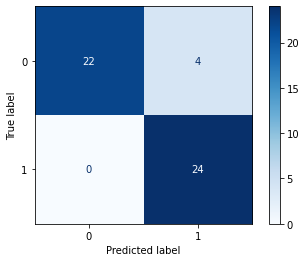

In [14]:
conf_matrix = confusion_matrix(y_val_women, y_pred_women)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_logistic_reg.classes_)
disp.plot(cmap='Blues')

<h5>Logistic Regression for Men</h5>

In [15]:
# define the parameter grid for grid search
param_grid = {
    'penalty': ['l1', 'l2'], # l1 lasso l2 ridge
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
}
logistic_reg = LogisticRegression(max_iter=1000, random_state=15, solver='liblinear')
# perform cross-validated grid search
grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)
# get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# initialize Logistic Regression with best parameters
best_logistic_reg = LogisticRegression(**best_params, solver='liblinear', max_iter=1000, random_state=15)

# fit the model on the entire training set
best_logistic_reg.fit(X_train_men, y_train_men)

# extract feature importances
feature_importances = np.abs(best_logistic_reg.coef_).sum(axis=0)

print("Feature Importances:")
for importance, feature in sorted(zip(feature_importances, X_train_men.columns), reverse=True):
    print(f"Feature {feature}: {importance}")

Best parameters: {'C': 10, 'penalty': 'l1'}
Feature Importances:
Feature tr9: 6.410559205051642
Feature tr24: 4.970512465689557
Feature tr15: 3.813586004801649
Feature tr11: 2.3297320320351016
Feature tr35: 2.3053449776004107
Feature tr4: 2.187998840093371
Feature tr13: 2.0723259101303464
Feature tr41: 1.819829996225695
Feature tr3: 1.70827682437816
Feature tr20: 1.150709883800514
Feature tr8: 0.7549882317699356
Feature tr14: 0.3872783421481149
Feature tr27: 0.288903380184703
Feature tr40: 0.2835290243613084
Feature tr18: 0.1396400199825687
Feature tr21: 0.0
Feature tr1: 0.0


In [16]:
y_pred_men = best_logistic_reg.predict(X_val_men)

# compute evaluation metrics
accuracy = accuracy_score(y_val_men, y_pred_men)
precision = precision_score(y_val_men, y_pred_men)
recall = recall_score(y_val_men, y_pred_men)
f1 = f1_score(y_val_men, y_pred_men)
roc_auc = roc_auc_score(y_val_men, y_pred_men)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.8235294117647058
precision: 0.8636363636363636
recall: 0.76
f1: 0.8085106382978724
roc_auc: 0.8223076923076923


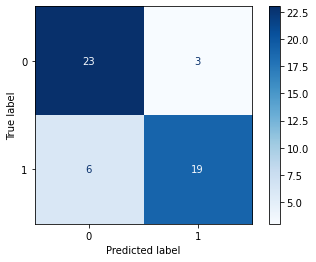

In [17]:
conf_matrix = confusion_matrix(y_val_men, y_pred_men)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_logistic_reg.classes_)
disp.plot(cmap='Blues')

<h3>AdaBoost</h3>
<p>
AdaBoost is an ensemble learning method that combines multiple weak classifier to create a strong classifier. It iteratively trains a series of weak learners, each focusing on the instances that were misclassified by the previous ones.

It can handle both numerical and categorical features. No specific preprocessing is required, but missing values may need to be handled. 

AdaBoost outputs class labels for classification tasks. It can also provide information about the weights assigned to each weak learner and their contribution to the final decision. 
</p>

<h5>AdaBoost for Women</h5>

In [18]:
param_grid = {
    'n_estimators': [1, 2, 5, 10, 20, 30, 40, 50, 100, 200, 500],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R'] 
}
adaboost = AdaBoostClassifier(random_state=15)

grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_adaboost = AdaBoostClassifier(**best_params, random_state=15)

# fit the model on the entire training set
best_adaboost.fit(X_train_women, y_train_women)

feature_importances = best_adaboost.feature_importances_

print("Feature Importances:")
for importance, feature in sorted(zip(feature_importances, X_train_women.columns), reverse=True):
    print(f"Feature {feature}: {importance}")

KeyboardInterrupt: 

In [ ]:
y_pred_women = best_adaboost.predict(X_val_women)

# compute evaluation metrics
accuracy = accuracy_score(y_val_women, y_pred_women)
precision = precision_score(y_val_women, y_pred_women)
recall = recall_score(y_val_women, y_pred_women)
f1 = f1_score(y_val_women, y_pred_women)
roc_auc = roc_auc_score(y_val_women, y_pred_women)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.8
precision: 0.7916666666666666
recall: 0.7916666666666666
f1: 0.7916666666666666
roc_auc: 0.7996794871794872


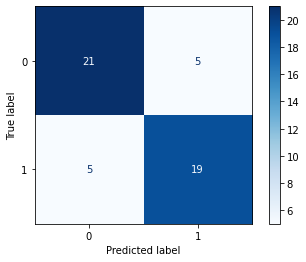

In [ ]:
conf_matrix = confusion_matrix(y_val_women, y_pred_women)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_adaboost.classes_)
disp.plot(cmap='Blues')

<h5>AdaBoost for Men</h5>

In [ ]:
param_grid = {
    'n_estimators': [1, 2, 5, 10, 20, 30, 40, 50, 100, 200, 500],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R'] 
}
adaboost = AdaBoostClassifier(random_state=15)

grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_adaboost = AdaBoostClassifier(**best_params, random_state=15)

# fit the model on the entire training set
best_adaboost.fit(X_train_men, y_train_men)

feature_importances = best_adaboost.feature_importances_

print("Feature Importances:")
for importance, feature in sorted(zip(feature_importances, X_train_men.columns), reverse=True):
    print(f"Feature {feature}: {importance}")

Best parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 10}
Feature Importances:
Feature tr34: 0.2
Feature tr9: 0.1
Feature tr6: 0.1
Feature tr40: 0.1
Feature tr4: 0.1
Feature tr29: 0.1
Feature tr21: 0.1
Feature tr18: 0.1
Feature tr15: 0.1
Feature tr8: 0.0
Feature tr35: 0.0
Feature tr28: 0.0
Feature tr20: 0.0
Feature tr19: 0.0
Feature tr14: 0.0
Feature tr13: 0.0
Feature tr11: 0.0


In [ ]:
y_pred_men = best_adaboost.predict(X_val_men)

# compute evaluation metrics
accuracy = accuracy_score(y_val_men, y_pred_men)
precision = precision_score(y_val_men, y_pred_men)
recall = recall_score(y_val_men, y_pred_men)
f1 = f1_score(y_val_men, y_pred_men)
roc_auc = roc_auc_score(y_val_men, y_pred_men)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.9607843137254902
precision: 0.9259259259259259
recall: 1.0
f1: 0.9615384615384615
roc_auc: 0.9615384615384616


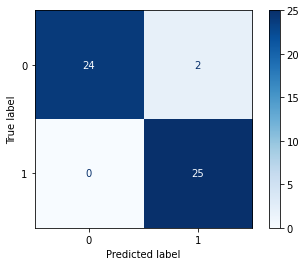

In [ ]:
conf_matrix = confusion_matrix(y_val_men, y_pred_men)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_adaboost.classes_)
disp.plot(cmap='Blues')

<h3>Support Vector Machine</h3>
<p>
SVM is a supervised learning algorithm that constructs a hyperplane or set of hyperplanes in a high-dimensional space to separate classes. It's effective in high-dimensional spaces and for cases where the number of dimensions exceeds the number of samples. 

It works best with numerical input features. Feature scaling is recommended, and categorical variables may need to be encoded.

SVM outputs class labels for classification tasks. It can also provide information about the separating hyperplane(s) and support vectors, which are the data points closest to the decision boundary.
</p>

<h5>Support Vector Machine for Women</h5>

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf', 'poly', 'sigmoid']
}  

svm = SVC(random_state=15)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_svm = SVC(**best_params, random_state=15)

best_svm.fit(X_train_women, y_train_women)

Best parameters: {'C': 10, 'gamma': 0.0001, 'kernel': 'sigmoid'}


SVC(C=10, gamma=0.0001, kernel='sigmoid', random_state=32)

In [ ]:
perm_importance = permutation_importance(best_svm, X_train_women, y_train_women, n_repeats=10, random_state=15)
feature_importance_scores = perm_importance.importances_mean
for importance, feature in sorted(zip(feature_importance_scores, X_train_women.columns), reverse=True):
    print(f"Feature {feature}: {importance}")

Feature tr21: 0.01758241758241762
Feature tr9: 0.016483516483516526
Feature tr15: 0.014285714285714346
Feature tr14: 0.013186813186813218
Feature tr40: 0.009890109890109921
Feature tr29: 0.008791208791208826
Feature tr8: 0.0076923076923077205
Feature tr28: 0.006593406593406614
Feature tr4: 0.005494505494505508
Feature tr35: 0.005494505494505508
Feature tr11: 0.004395604395604424
Feature tr19: 0.0010989010989011171
Feature tr6: 0.0
Feature tr20: 0.0
Feature tr18: 0.0
Feature tr13: 0.0
Feature tr34: -0.007692307692307642


In [ ]:
y_pred_women = best_svm.predict(X_val_women)

# compute evaluation metrics
accuracy = accuracy_score(y_val_women, y_pred_women)
precision = precision_score(y_val_women, y_pred_women)
recall = recall_score(y_val_women, y_pred_women)
f1 = f1_score(y_val_women, y_pred_women)
roc_auc = roc_auc_score(y_val_women, y_pred_women)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.86
precision: 0.8148148148148148
recall: 0.9166666666666666
f1: 0.8627450980392156
roc_auc: 0.8621794871794871


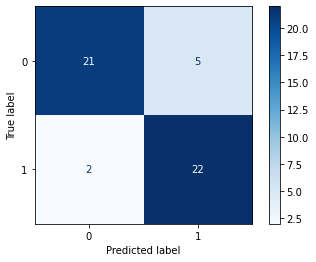

In [ ]:
conf_matrix = confusion_matrix(y_val_women, y_pred_women)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_adaboost.classes_)
disp.plot(cmap='Blues')

<h5>Support Vector Machine for Men</h5>

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf', 'poly', 'sigmoid']
}  

svm = SVC(random_state=15)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_svm = SVC(**best_params, random_state=15)

best_svm.fit(X_train_men, y_train_men)

y_pred_men = best_svm.predict(X_val_men)

Best parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'poly'}


In [ ]:
perm_importance = permutation_importance(best_svm, X_train_men, y_train_men, n_repeats=10, random_state=15)
feature_importance_scores = perm_importance.importances_mean
for importance, feature in sorted(zip(feature_importance_scores, X_train_men.columns), reverse=True):
    print(f"Feature {feature}: {importance}")

Feature tr34: 0.2315217391304348
Feature tr6: 0.12173913043478261
Feature tr15: 0.11630434782608697
Feature tr9: 0.11413043478260869
Feature tr40: 0.0673913043478261
Feature tr21: 0.06521739130434784
Feature tr4: 0.05978260869565218
Feature tr35: 0.03260869565217393
Feature tr8: 0.022826086956521753
Feature tr29: 0.017391304347826098
Feature tr28: 0.01304347826086959
Feature tr13: 0.01086956521739132
Feature tr18: 0.005434782608695676
Feature tr19: 0.0021739130434782817
Feature tr20: 0.0010869565217391576
Feature tr11: -0.002173913043478237
Feature tr14: -0.0032608695652173725


In [ ]:
y_pred_men = best_svm.predict(X_val_men)

# compute evaluation metrics
accuracy = accuracy_score(y_val_men, y_pred_men)
precision = precision_score(y_val_men, y_pred_men)
recall = recall_score(y_val_men, y_pred_men)
f1 = f1_score(y_val_men, y_pred_men)
roc_auc = roc_auc_score(y_val_men, y_pred_men)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.9019607843137255
precision: 0.9545454545454546
recall: 0.84
f1: 0.8936170212765958
roc_auc: 0.9007692307692308


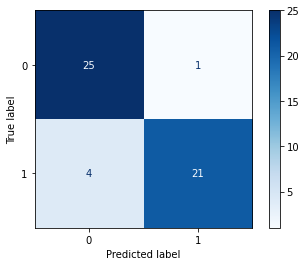

In [ ]:
conf_matrix = confusion_matrix(y_val_men, y_pred_men)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_adaboost.classes_)
disp.plot(cmap='Blues')

<h3>Random Forrest</h3>
<p>
Random Forest is an ensemble learning method that constructs a multitude of decision trees during training and outputs the mode of the classes (classification) or the mean prediction (regression) of the individual trees.

It can handle both numerical and categorical features. No specific preprocessing is required, but missing values may need to be handled.

Random Forest outputs class labels for classification tasks or continuous values for regression tasks. Additionally, it can provide feature importances, which indicate the relative importance of each feature in the model.
</p>

<h5>Random Forrest for Women</h5>

In [ ]:
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

rf_classifier = RandomForestClassifier(random_state=15)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_rf_classifier = RandomForestClassifier(**best_params, random_state=15)

best_rf_classifier.fit(X_train_women, y_train_women)

Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}


RandomForestClassifier(max_features='log2', min_samples_split=5,
                       n_estimators=10, random_state=32)

In [ ]:
feature_importances = best_rf_classifier.feature_importances_
for importance, feature in sorted(zip(feature_importances, X_train_women.columns), reverse=True):
    print(f"Feature {feature}: {importance}")

Feature tr34: 0.13941695710019705
Feature tr29: 0.11417686271599009
Feature tr9: 0.11325169522799848
Feature tr28: 0.10406813455777802
Feature tr40: 0.09082108732512453
Feature tr21: 0.0785945474774012
Feature tr15: 0.07578217611755336
Feature tr8: 0.05720722935635316
Feature tr19: 0.04471753056141828
Feature tr20: 0.03168622090188938
Feature tr18: 0.03091690266701284
Feature tr13: 0.03026093488767585
Feature tr35: 0.03013850151323138
Feature tr14: 0.02593273121795893
Feature tr6: 0.020878283247287903
Feature tr4: 0.007223169596846198
Feature tr11: 0.004927035528283402


In [ ]:
y_pred_women = best_rf_classifier.predict(X_val_women)

# compute evaluation metrics
accuracy = accuracy_score(y_val_women, y_pred_women)
precision = precision_score(y_val_women, y_pred_women)
recall = recall_score(y_val_women, y_pred_women)
f1 = f1_score(y_val_women, y_pred_women)
roc_auc = roc_auc_score(y_val_women, y_pred_women)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.82
precision: 0.8260869565217391
recall: 0.7916666666666666
f1: 0.8085106382978724
roc_auc: 0.8189102564102564


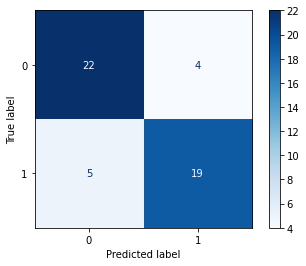

In [ ]:
conf_matrix = confusion_matrix(y_val_women, y_pred_women)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_rf_classifier.classes_)
disp.plot(cmap='Blues')

<h5>Random Forrest for Men</h5>

In [ ]:
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

rf_classifier = RandomForestClassifier(random_state=15)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_rf_classifier = RandomForestClassifier(**best_params, random_state=15)

best_rf_classifier.fit(X_train_men, y_train_men)

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=200, random_state=32)

In [ ]:
feature_importances = best_rf_classifier.feature_importances_
for importance, feature in sorted(zip(feature_importances, X_train_men.columns), reverse=True):
    print(f"Feature {feature}: {importance}")

Feature tr21: 0.18734955973497533
Feature tr34: 0.12825465567711897
Feature tr6: 0.12356460517744369
Feature tr40: 0.10466705014997393
Feature tr14: 0.0734630018314462
Feature tr19: 0.0633617968105485
Feature tr15: 0.061247820492848236
Feature tr28: 0.051140824288532796
Feature tr18: 0.035750354839563334
Feature tr29: 0.03361684718791206
Feature tr9: 0.026055006266699744
Feature tr13: 0.024806697227551616
Feature tr8: 0.024383411047671805
Feature tr35: 0.020996014486244313
Feature tr4: 0.020362967519091463
Feature tr11: 0.013173842072925521
Feature tr20: 0.007805545189452369


In [ ]:
y_pred_men = best_rf_classifier.predict(X_val_men)

# compute evaluation metrics
accuracy = accuracy_score(y_val_men, y_pred_men)
precision = precision_score(y_val_men, y_pred_men)
recall = recall_score(y_val_men, y_pred_men)
f1 = f1_score(y_val_men, y_pred_men)
roc_auc = roc_auc_score(y_val_men, y_pred_men)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.9607843137254902
precision: 0.96
recall: 0.96
f1: 0.96
roc_auc: 0.9607692307692307


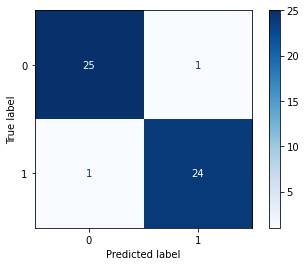

In [ ]:
conf_matrix = confusion_matrix(y_val_men, y_pred_men)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_rf_classifier.classes_)
disp.plot(cmap='Blues')

<h3>k-Nearest Neighbours (KNN)</h3>
<p>
KNN is a non-parametric and instance-based learning algorithm that stores all available cases and classifies new cases based on a similarity measure (e.g., distance functions).

It works best with numerical input features. Feature scaling is essential as it's based on computing distances between data points. Categorical variables may need to be encoded.

KNN outputs class labels for classification tasks based on the majority class among the k-nearest neighbors of the new instance.
</p>

<h5>k-Nearest Neighbours (KNN) for Women</h5>

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],     
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_classifier = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_knn_classifier = KNeighborsClassifier(**best_params)

best_knn_classifier.fit(X_train_women, y_train_women)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}


KNeighborsClassifier(metric='manhattan', n_neighbors=9)

In [ ]:
y_pred_women = best_knn_classifier.predict(X_val_women)

# compute evaluation metrics
accuracy = accuracy_score(y_val_women, y_pred_women)
precision = precision_score(y_val_women, y_pred_women)
recall = recall_score(y_val_women, y_pred_women)
f1 = f1_score(y_val_women, y_pred_women)
roc_auc = roc_auc_score(y_val_women, y_pred_women)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.82
precision: 0.7777777777777778
recall: 0.875
f1: 0.823529411764706
roc_auc: 0.8221153846153845


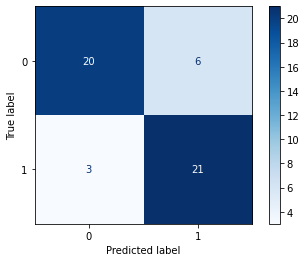

In [ ]:
conf_matrix = confusion_matrix(y_val_women, y_pred_women)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_rf_classifier.classes_)
disp.plot(cmap='Blues')

<h5>k-Nearest Neighbours (KNN) for Men</h5>

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],     
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_classifier = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_knn_classifier = KNeighborsClassifier(**best_params)

best_knn_classifier.fit(X_train_men, y_train_men)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

In [ ]:
y_pred_men = best_rf_classifier.predict(X_val_men)

# compute evaluation metrics
accuracy = accuracy_score(y_val_men, y_pred_men)
precision = precision_score(y_val_men, y_pred_men)
recall = recall_score(y_val_men, y_pred_men)
f1 = f1_score(y_val_men, y_pred_men)
roc_auc = roc_auc_score(y_val_men, y_pred_men)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.9607843137254902
precision: 0.96
recall: 0.96
f1: 0.96
roc_auc: 0.9607692307692307


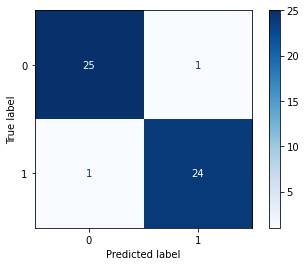

In [ ]:
conf_matrix = confusion_matrix(y_val_men, y_pred_men)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_rf_classifier.classes_)
disp.plot(cmap='Blues')

<h3>Cross Validation for Support Vector Machine</h3>

<h5>SVM Model Cross Validation for Women</h5>

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf', 'poly', 'sigmoid']
}  

svm = SVC(random_state=15)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_svm = SVC(**best_params, random_state=15)

best_svm.fit(X_train_women, y_train_women)

Best parameters: {'C': 10, 'gamma': 0.0001, 'kernel': 'sigmoid'}


SVC(C=10, gamma=0.0001, kernel='sigmoid', random_state=32)

In [ ]:
X_combined = np.concatenate((X_train_women, X_val_women), axis=0)
y_combined = np.concatenate((y_train_women, y_val_women), axis=0)

best_svm = SVC(**best_params, random_state=15)

cv_scores = cross_val_score(best_svm, X_combined, y_combined, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores:")
print(cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

best_svm.fit(X_combined, y_combined)


y_pred_test = best_svm.predict(X_test_women)

accuracy_test = accuracy_score(y_test_women, y_pred_test)
precision_test = precision_score(y_test_women, y_pred_test)
recall_test = recall_score(y_test_women, y_pred_test)
f1_test = f1_score(y_test_women, y_pred_test)
roc_auc_test = roc_auc_score(y_test_women, y_pred_test)

print("\nTest Set Evaluation:")
print(f'Accuracy: {accuracy_test}')
print(f'Precision: {precision_test}')
print(f'Recall: {recall_test}')
print(f'F1-score: {f1_test}')
print(f'ROC AUC: {roc_auc_test}')


Cross-Validation Accuracy Scores:
[0.86206897 0.82142857 0.89285714 0.82142857 0.89285714]
Mean CV Accuracy: 0.858128078817734

Test Set Evaluation:
Accuracy: 0.8611111111111112
Precision: 0.875
Recall: 0.8235294117647058
F1-score: 0.8484848484848485
ROC AUC: 0.8591331269349844


/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


<h5>SVM Model Cross Validation for Men</h5>

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf', 'poly', 'sigmoid']
}  

svm = SVC(random_state=15)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_svm = SVC(**best_params, random_state=15)

best_svm.fit(X_train_men, y_train_men)

y_pred_men = best_svm.predict(X_val_men)

Best parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'poly'}


In [ ]:
X_combined = np.concatenate((X_train_men, X_val_men), axis=0)
y_combined = np.concatenate((y_train_men, y_val_men), axis=0)

best_svm = SVC(**best_params, random_state=15)

cv_scores = cross_val_score(best_svm, X_combined, y_combined, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores:")
print(cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

best_svm.fit(X_combined, y_combined)


y_pred_test = best_svm.predict(X_test_men)

accuracy_test = accuracy_score(y_test_men, y_pred_test)
precision_test = precision_score(y_test_men, y_pred_test)
recall_test = recall_score(y_test_men, y_pred_test)
f1_test = f1_score(y_test_men, y_pred_test)
roc_auc_test = roc_auc_score(y_test_men, y_pred_test)

print("\nTest Set Evaluation:")
print(f'Accuracy: {accuracy_test}')
print(f'Precision: {precision_test}')
print(f'Recall: {recall_test}')
print(f'F1-score: {f1_test}')
print(f'ROC AUC: {roc_auc_test}')


Cross-Validation Accuracy Scores:
[0.96551724 0.93103448 0.86206897 0.96428571 0.92857143]
Mean CV Accuracy: 0.9302955665024631

Test Set Evaluation:
Accuracy: 0.9722222222222222
Precision: 0.9444444444444444
Recall: 1.0
F1-score: 0.9714285714285714
ROC AUC: 0.9736842105263158


/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


<h1>ANYTHING BELOW IS WORK IN PROGRESS</h1>